In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
import sklearn.grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pickle

%matplotlib osx

In [2]:
"""
Read in train and test as Pandas DataFrames
"""

df_train = pd.read_csv("train.csv")
#df_test = pd.read_csv("test.csv")


In [3]:
#store gap values
Y_train = df_train.gap.values
#row where testing examples start
test_idx = df_train.shape[0]
#delete 'Id' column
df_test = df_test.drop(['Id'], axis=1)
#delete 'gap' column
df_train = df_train.drop(['gap'], axis=1)

NameError: name 'df_test' is not defined

In [ ]:
#DataFrame with all train and test examples so we can more easily apply feature engineering on
df_all = pd.concat((df_train, df_test), axis=0)
df_all.head()

In [ ]:
"""
Example Feature Engineering

this calculates the length of each smile string and adds a feature column with those lengths
Note: this is NOT a good feature and will result in a lower score!
"""
#smiles_len = np.vstack(df_all.smiles.astype(str).apply(lambda x: len(x)))
#df_all['smiles_len'] = pd.DataFrame(smiles_len)


In [ ]:
#Drop the 'smiles' column
df_all = df_all.drop(['smiles'], axis=1)
vals = df_all.values
X_train = vals[:test_idx]
X_test = vals[test_idx:]
print "Train features:", X_train.shape
print "Train gap:", Y_train.shape
print "Test features:", X_test.shape

In [ ]:
LR = LinearRegression()
LR.fit(X_train, Y_train)
LR_pred = LR.predict(X_test)

In [ ]:
# PCA testing
pca = PCA(n_components=27)
pca.fit(X_train)

In [ ]:
X_train_pca = pca.fit_transform(X_train)

In [ ]:
LR_pca = LinearRegression()
LR_pca.fit(X_train_pca,Y_train)
LR_pred_pca = LR_pca.predict(pca.transform(X_test))
RF = RandomForestRegressor()
RF.fit(X_train, Y_train)
RF_pred = RF.predict(X_test)

In [210]:
def write_to_file(filename, predictions):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(predictions):
            f.write(str(i+1) + "," + str(p) + "\n")
#write_to_file("pca_preds.csv", LR_pred_pca)

In [ ]:
plt.scatter(feature4, Y_train, alpha=0.1)
plt.show()

In [208]:
X_dana_train = np.load("X_train_new.npy")
X_dana_test = np.load("x_test_new.npy")

In [ ]:
#retry PCA w/ Dana's features
pca_dana = PCA()
pca_dana.fit(X_dana_train)

In [ ]:
X_pca_dana_train = pca_dana.fit_transform(X_dana_train)

In [ ]:
col_names_dana = ["feature_reduced" + str(i) for i in range(0,258)]
df_pca_dana_X = pd.DataFrame(X_pca_dana_train, columns=col_names_dana)

In [ ]:
plt.scatter(df_pca_dana_X.feature_reduced0, Y_train, alpha=0.05)
plt.show()

In [ ]:
# PCA Regression with Dana's new features
LR_pca_dana = LinearRegression()
LR_pca_dana.fit(X_pca_dana_train,Y_train)
LR_pred_pca_dana = LR_pca_dana.predict(pca_dana.transform(X_dana_test))
# write_to_file("pca_preds_dana.csv", LR_pred_pca_dana)

In [ ]:
#cross-validation; Dana_PCA vs. Dana vs. Simple
LR_pca_scores = LinearRegression()
scores_pca_dana = cross_validation.cross_val_score(LR_pca_scores, X_pca_dana_train, Y_train, cv=5)
scores_simple = cross_validation.cross_val_score(LR_pca_scores, X_train, Y_train, cv=5)
scores_dana = cross_validation.cross_val_score(LR_pca_scores, X_dana_train, Y_train, cv=5)

In [5]:
pca = PCA()
standard = StandardScaler()
X_dana_train_pca = pca.fit_transform(standard.fit_transform(X_dana_train))


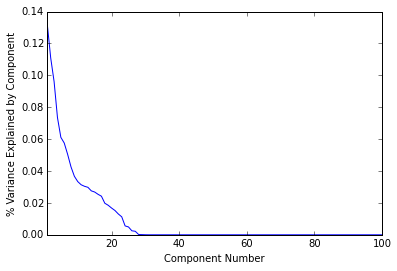

In [240]:
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.xlim(1,100)
plt.xlabel("Component Number")
plt.ylabel("% Variance Explained by Component")


In [246]:
component_weights = pd.DataFrame(zip(*pca.components_)[-2:])
display(component_weights.ix[:,0:5])


,0,1,2,3,4,5
0,0.103918,-0.166884,-0.148352,-0.381448,-0.118675,0.376677
1,0.099865,-0.154952,-0.153087,-0.395083,-0.118098,0.368940


In [ ]:
# Run gridsearch over k:[1,50], n:[1,10], uniform vs. distance weighting methods
# ------------------------------------------------------------------------------
df_X_dana_train_pca = pd.DataFrame(X_dana_train_pca)
searches = []
for i in range(0,10):
    X_input = df_X_dana_train_pca.ix[:,0:i]
    params = {
        'weights': ['uniform','distance'],
        'n_neighbors': range(1,51)
    }

    if __name__ == "__main__":
        knn_comprehensive_search = GridSearchCV(KNeighborsRegressor(), params, n_jobs=6, pre_dispatch=1, verbose=4, cv=3)
        knn_comprehensive_search.fit(X_input,Y_train)
        searches.append(knn_comprehensive_search)

# pickle the scores in case we lose the kernel
scores_f = open("knn_grid_search_scores.npy", "w")
grid_scores = [i.grid_scores_ for i in searches]
pickler = pickle.Pickler(scores_f)
pickler.dump(grid_scores)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


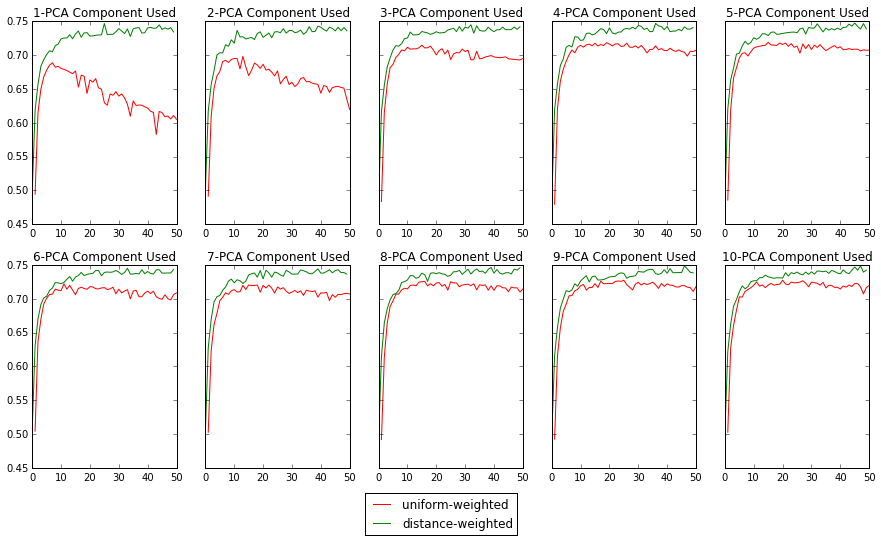

In [247]:
# plot cross-val scores from gridsearch
distance = []
uniform = []
# iterate across number of components
for n_component_search in grid_scores:
    # iterate across all combinations
    n_distance = []
    n_uniform = []
    for j in n_component_search:
        if j[0]["weights"] == "uniform":
            n_uniform.append((j[1],np.std(j[2])))
        else:
            n_distance.append((j[1],np.std(j[2])))
    distance.append(n_distance)
    uniform.append(n_uniform)
f, axarr = plt.subplots(2,5, sharey=True, figsize=(15,8))
x = range(1,51)
axarr = axarr.flatten()
for i in range (0,10):
    curr_unif, curr_dist = uniform[i], distance[i]
    u,d = axarr[i].plot(x, zip(*curr_unif)[0],"r-", zip(*curr_dist)[0], "g-")
    axarr[i].set_title(str(i+1) + "-PCA Component Used")
plt.figlegend([u,d], ["uniform-weighted","distance-weighted"], loc="lower center")

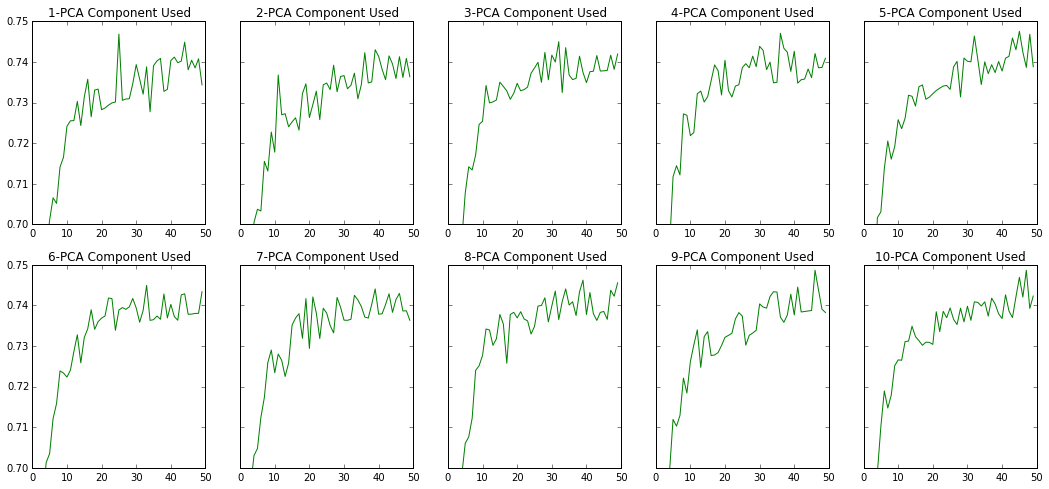

In [142]:
# plot only distance weighted scores
f, axarr = plt.subplots(2,5, sharey=True, figsize=(18,8))
x = range(1,51)
axarr = axarr.flatten()
for i in range (0,10):
    curr_dist = distance[i]
    axarr[i].plot(zip(*curr_dist)[0], "g-")
    axarr[i].set_ylim([0.70,0.75])
    axarr[i].set_title(str(i+1) + "-PCA Component Used")

In [155]:
for s in searches:
    print s.best_score_, s.best_params_, np.std(s.grid_scores_[s.best_params_["n_neighbors"]-1][2])

0.746878823591 {'n_neighbors': 26, 'weights': 'distance'} 0.00367985106371
0.743019843767 {'n_neighbors': 40, 'weights': 'distance'} 0.0053025561181
0.745000282233 {'n_neighbors': 33, 'weights': 'distance'} 0.00281825670985
0.747067006509 {'n_neighbors': 37, 'weights': 'distance'} 0.00435707107225
0.747571982548 {'n_neighbors': 46, 'weights': 'distance'} 0.0012445647374
0.74494744457 {'n_neighbors': 34, 'weights': 'distance'} 0.0056838154876
0.744077530055 {'n_neighbors': 40, 'weights': 'distance'} 0.00648437901621
0.746242874166 {'n_neighbors': 40, 'weights': 'distance'} 0.00505693404284
0.748680972114 {'n_neighbors': 47, 'weights': 'distance'} 0.00204178660626
0.748667919066 {'n_neighbors': 48, 'weights': 'distance'} 0.00517379623359


In [188]:
avg_d = [zip(*d)[0] for d in distance]
avg = [np.mean(i) for i in zip(*avg_d)]
print np.argmax(avg)

In [213]:
for s in searches:
    print s.best_score_, s.best_params_

0.746878823591 {'n_neighbors': 26, 'weights': 'distance'}
0.743019843767 {'n_neighbors': 40, 'weights': 'distance'}
0.745000282233 {'n_neighbors': 33, 'weights': 'distance'}
0.747067006509 {'n_neighbors': 37, 'weights': 'distance'}
0.747571982548 {'n_neighbors': 46, 'weights': 'distance'}
0.74494744457 {'n_neighbors': 34, 'weights': 'distance'}
0.744077530055 {'n_neighbors': 40, 'weights': 'distance'}
0.746242874166 {'n_neighbors': 40, 'weights': 'distance'}
0.748680972114 {'n_neighbors': 47, 'weights': 'distance'}
0.748667919066 {'n_neighbors': 48, 'weights': 'distance'}


In [214]:
searches_four_five = []
for i in range(4,6):
    X_input = df_X_dana_train_pca.ix[:,0:i]
    params = {
        'n_neighbors': range(51,101)
    }

    if __name__ == "__main__":
        knn_comprehensive_search_four_five = GridSearchCV(KNeighborsRegressor(weights="distance"), params, n_jobs=7, pre_dispatch=1, verbose=6, cv=5)
        knn_comprehensive_search_four_five.fit(X_input,Y_train)
        searches_four_five.append(knn_comprehensive_search_four_five)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:  4.0min
[Parallel(n_jobs=7)]: Done  49 tasks      | elapsed: 21.4min
[Parallel(n_jobs=7)]: Done 112 tasks      | elapsed: 52.8min
[Parallel(n_jobs=7)]: Done 199 tasks      | elapsed: 105.5min
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed: 135.5min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=52 ..................................................
[CV] n_neighbors=52 ..................................................
[CV] ......................... n_neighbors=51, score=0.740078 -  15.0s[CV] ......................... n_neighbors=51, score=0.739660 -  15.1s[CV] ......................... n_neighbors=51, score=0.741307 -  15.4s[CV] ......................... n_neighbors=51, score=0.738829 -  16.1s[CV] ......................... n_neighbors=51, score=0.739476 -  15.3s[CV] ......................... n_neighbors=52, score=0.740157 -  14.5s[CV] ................

[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:  4.1min
[Parallel(n_jobs=7)]: Done  49 tasks      | elapsed: 20.9min
[Parallel(n_jobs=7)]: Done 112 tasks      | elapsed: 60.2min
[Parallel(n_jobs=7)]: Done 199 tasks      | elapsed: 116.8min
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed: 154.9min finished


[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=51 ..................................................
[CV] n_neighbors=52 ..................................................
[CV] n_neighbors=52 ..................................................
[CV] ......................... n_neighbors=51, score=0.740363 -  18.5s[CV] ......................... n_neighbors=51, score=0.739519 -  20.3s[CV] ......................... n_neighbors=51, score=0.741621 -  19.9s[CV] ......................... n_neighbors=51, score=0.738775 -  19.7s[CV] ......................... n_neighbors=51, score=0.738905 -  17.5s[CV] ......................... n_neighbors=52, score=0.750001 -  17.4s[CV] ......................... n_neighbors=52, score=0.739631 -  17.7s






[CV] n

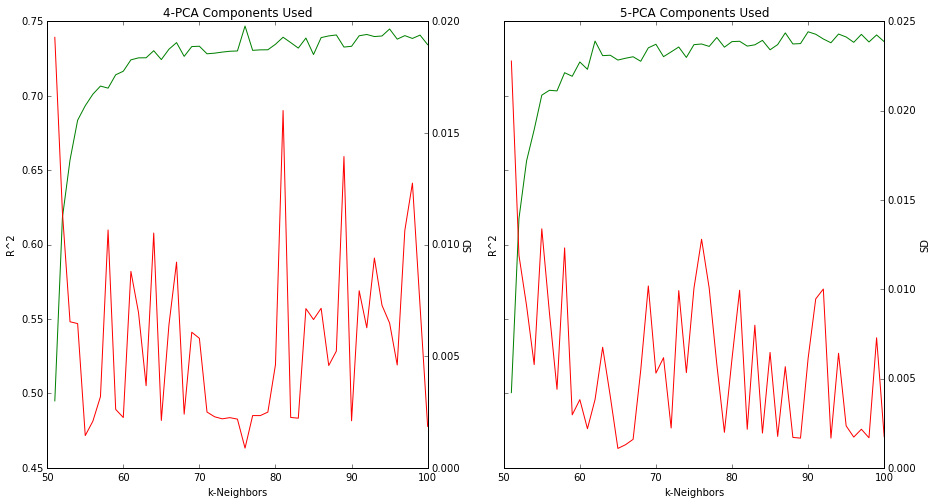

In [261]:
# plot cross-val scores from gridsearch w/ standard deviation
distance_ff = []
uniform_ff = []
# iterate across number of components
for n in [i.grid_scores_ for i in searches_four_five]:
    # iterate across all combinations
    n_distance = []
    n_uniform = []
    for j in n:
        n_distance.append((j[1],np.std(j[2])))
    distance_ff.append(n_distance)
f, axarr = plt.subplots(1,2, sharey=True, figsize=(15,8))
x = range(51,101)
axarr = axarr.flatten()
for i in range (0,2):
    curr_dist = distance[i]
    axarr[i].plot(x, zip(*curr_dist)[0], "g-")
    axarr[i].set_ylabel("R^2")
    twin = axarr[i].twinx()
    twin.plot(x,zip(*curr_dist)[1],"r-")
    twin.set_ylabel("SD")
    axarr[i].set_xlabel("k-Neighbors")
    axarr[i].set_title(str(i+4) + "-PCA Components Used")

In [ ]:
ten_component = searches[9]
X_dana_test_pca = pd.DataFrame(pca.transform(standard.transform(X_dana_test))).ix[:,0:9]
write_to_file("48_ten_component_preds_standardized.csv", ten_component.predict(X_dana_test_pca))

In [262]:
# test new dsets with bond character features
X_dana_train = np.load('X_train_new_bonds.npy')
X_dana_test = np.load('X_test_new_bonds.npy')

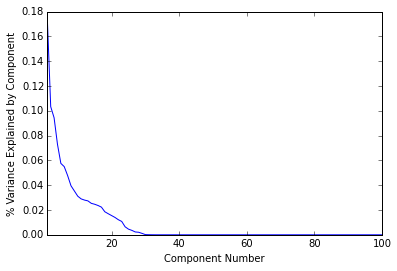

In [263]:
pca_bf = PCA()
standard_bf = StandardScaler()
X_dana_train_pca_bf = pca_bf.fit_transform(standard_bf.fit_transform(X_dana_train))
plt.plot(range(1,len(pca_bf.explained_variance_ratio_)+1),pca_bf.explained_variance_ratio_)
plt.xlim(1,100)
plt.xlabel("Component Number")
plt.ylabel("% Variance Explained by Component")


In [266]:
# fit and predict a 10 component, 48 neighbor KNN with new bond character features
df_X_dana_train_pca_bf = pd.DataFrame(X_dana_train_pca_bf)
X_train_input_bf = df_X_dana_train_pca_bf.ix[:,0:9]
knn_bf = KNeighborsRegressor(n_neighbors=48, weights="distance")
knn_bf.fit(X_train_input_bf, Y_train)
X_test_input_bf = pd.DataFrame(pca_bf.transform(standard_bf.fit_transform(X_dana_test))).ix[:,0:9]
preds_bf = knn_bf.predict(X_test_input_bf)

In [267]:
write_to_file("preds_bf.csv", preds_bf)

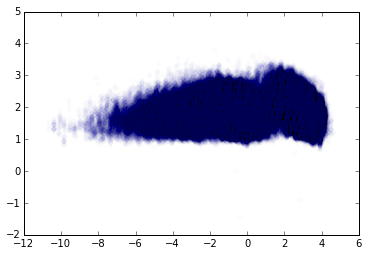

In [282]:
plt.scatter(X_train_input_bf.ix[:,0:0],Y_train, alpha=0.01)